<a href="https://colab.research.google.com/github/bansi1008/ndvi/blob/main/SAFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1**

The first and most critical step involves the implementation of an automated data ingestion system that can smoothly integrate with satellite imagery repositories mostly via APIs provided by the Copernicus Data Space Ecosystem or may be AWS open data registry. This pipeline will use scheduled tasks, such as cron jobs or cloud functions, to regularly fetch new Sentinel-2 images as soon as they become available.

In [11]:
!pip install rasterio numpy matplotlib

print("Libraries installed successfully!")

Libraries installed successfully!


In [12]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


step 2

In this step, the satellite images required for analysis are collected from the SAFE file B08 and B04. Currently due to access limitations and other factors this needs to be done manually, so Level-2 Sentinel-2 images were downloaded manually using the Copernicus Open Access Hub. This method allowed me to move on to the main work that is processing and analysis without losing time.

In [13]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

download_directory = "/content/drive/My Drive"
print(f"Set download directory to: {download_directory}")

def find_band_file(base_dir, band_name_part):
    for file in os.listdir(base_dir):
        if band_name_part in file and (file.endswith('.jp2') or file.endswith('.tif')):
            return os.path.join(base_dir, file)
    return None



red_band_path = find_band_file(download_directory, 'B04_10m')
nir_band_path = find_band_file(download_directory, 'B08_10m')



Set download directory to: /content/drive/My Drive


it's for the testing purpose

In [14]:
if not red_band_path or not nir_band_path:
    print("ERROR: Could not find B04_10m.jp2 and/or B08_10m.jp2 in your drive folder.")
    print(f"Check contents with: !ls -l '{download_directory}'")
else:
    print(f"Found Red band (B04): {red_band_path}")
    print(f"Found NIR band (B08): {nir_band_path}")


Found Red band (B04): /content/drive/My Drive/T30UWF_20250103T112451_B04_10m.jp2
Found NIR band (B08): /content/drive/My Drive/T30UWF_20250103T112451_B08_10m.jp2


step 3

Here, I read the downloaded Sentinel-2 image bands, namely red band (B04) and near-infrared band (B08) using Rasterio. The pixel values are read as arrays and transformed to floating-point ones to perform an accurate calculation. I normalize these reflectance values by dividing by 10,000 since reflectance values of Sentinel-2 are multiplied by this number before they are converted to reflectance. The profile metadata of the red band is also stored in order to preserve geospatial data that would be used at a later period.

In [15]:
with rasterio.open(red_band_path) as src_red:
    red = src_red.read(1).astype(float)
    profile = src_red.profile

with rasterio.open(nir_band_path) as src_nir:
    nir = src_nir.read(1).astype(float)

# Normalize reflectance: Sentinel-2 scaled by 10,000
red /= 10000.0
nir /= 10000.0


This code checks if the red and NIR bands have different dimensions, which can likely happen due to variations in the satellite data or preprocessing. If their shapes don’t match, it crops both arrays to the smallest common size so they align perfectly for further calculations

In [10]:
if red.shape != nir.shape:
    min_rows = min(red.shape[0], nir.shape[0])
    min_cols = min(red.shape[1], nir.shape[1])
    red = red[:min_rows, :min_cols]
    nir = nir[:min_rows, :min_cols]
    print(f"Warning: Bands had different shapes. Cropped to {red.shape}")


in here I handled the no-data or invalid value in both bands sometime a value of 0 often represents areas with no useful data, such as cloud cover, water bodies, or image edges. To prevent these from skewing the NDVI calculation, the code replaces all 0 values in both bands with NaN

In [16]:
red[red == 0] = np.nan
nir[nir == 0] = np.nan


**step 4 cloud masking**

I applied a cloud mask using the Sentinel-2 QA60 band, which can contains quality information about each pixel, that can incluse cloud coverage. This band encodes cloud presence using bit flags specifically bits 10 and 11 indicate clouds and cirrus clouds.

I first checked if the QA60 file was available, then read it and cropped it to match the dimensions of the NDVI image if needed. Using bitwise operations, I identified the pixels flagged as cloudy and set their corresponding NDVI values to -9999, which serves as a no-data marker. This helps ensure that cloudy pixels don’t interfere with the NDVI analysis or visualization.


In [17]:
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
cloud_mask_path = find_band_file(download_directory, 'QA60')  # QA60 contains cloud info

if cloud_mask_path:
    with rasterio.open(cloud_mask_path) as src_cloud:
        cloud_mask = src_cloud.read(1)
        cloud_mask = cloud_mask[:min_rows, :min_cols]  # Match shape if needed

    # Mask clouds (QA60: cloud bits are typically bits 10 and 11)
    cloud_pixels = ((cloud_mask & (1 << 10)) != 0) | ((cloud_mask & (1 << 11)) != 0)
    ndvi[cloud_pixels] = -9999  # Mark clouds as no-data
    print("Cloud masking applied.")


I calculated the NDVI value using the standard formula: (NIR - Red) / (NIR + Red). just in case there are still unexpected values so I used np.errstate

In [18]:
with np.errstate(divide='ignore', invalid='ignore'):
    ndvi = (nir - red) / (nir + red)

ndvi[np.isnan(ndvi)] = -9999
print("NDVI calculated successfully!")


NDVI calculated successfully!


step *4*

 I reproject the NDVI array from its original CRS  EPSG:4326 for Sentinel-2 to EPSG:27700 to ensure consistency with other UK spatial datasets. Using rasterio.warp.calculate_default_transform, I calculate  the appropriate affine transformation and target dimensions for the new projection. Then, with rasterio.warp.reproject, I reproject the NDVI data into the new coordinate system using nearest-neighbor resampling and update the raster metadata profile to reflect the new CRS, transform, width, and height, ensuring the output is properly georeferenced in EPSG:27700.

In [19]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:27700'
transform, width, height = calculate_default_transform(
    src_red.crs, dst_crs, ndvi.shape[1], ndvi.shape[0], *src_red.bounds
)

reprojected_ndvi = np.empty((height, width), dtype=np.float32)

reproject(
    source=ndvi,
    destination=reprojected_ndvi,
    src_transform=src_red.transform,
    src_crs=src_red.crs,
    dst_transform=transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

profile.update({
    'crs': dst_crs,
    'transform': transform,
    'width': width,
    'height': height
})


This section updates the metadata profile to prepare for saving the NDVI data as a GeoTIFF. I specify the output format (GTiff) and set the data type to float32, which is appropriate for continuous NDVI values.

In [20]:
profile.update(
    driver='GTiff',
    dtype=rasterio.float32,
    count=1,
    compress='lzw',
    nodata=-9999,
    width=ndvi.shape[1],
    height=ndvi.shape[0]
)


In [16]:
try:
    filename_parts = os.path.basename(red_band_path).split('_')
    filename_stem = f"{filename_parts[0]}_{filename_parts[1]}"
    output_ndvi_filename = f"ndvi_{filename_stem}.tif"
except IndexError:
    output_ndvi_filename = "ndvi_calculated_image.tif"

output_ndvi_path = os.path.join(download_directory, output_ndvi_filename)

with rasterio.open(output_ndvi_path, 'w', **profile) as dst:
    dst.write(ndvi.astype(rasterio.float32), 1)

print(f"NDVI GeoTIFF saved to: {output_ndvi_path}")


NDVI GeoTIFF saved to: /content/drive/My Drive/ndvi_T30UWF_20250103T112451.tif


This block opens the final NDVI GeoTIFF file stored in Google Drive and displays it as an image. Using rasterio, it reads the spatial raster data and plots it using matplotlib.

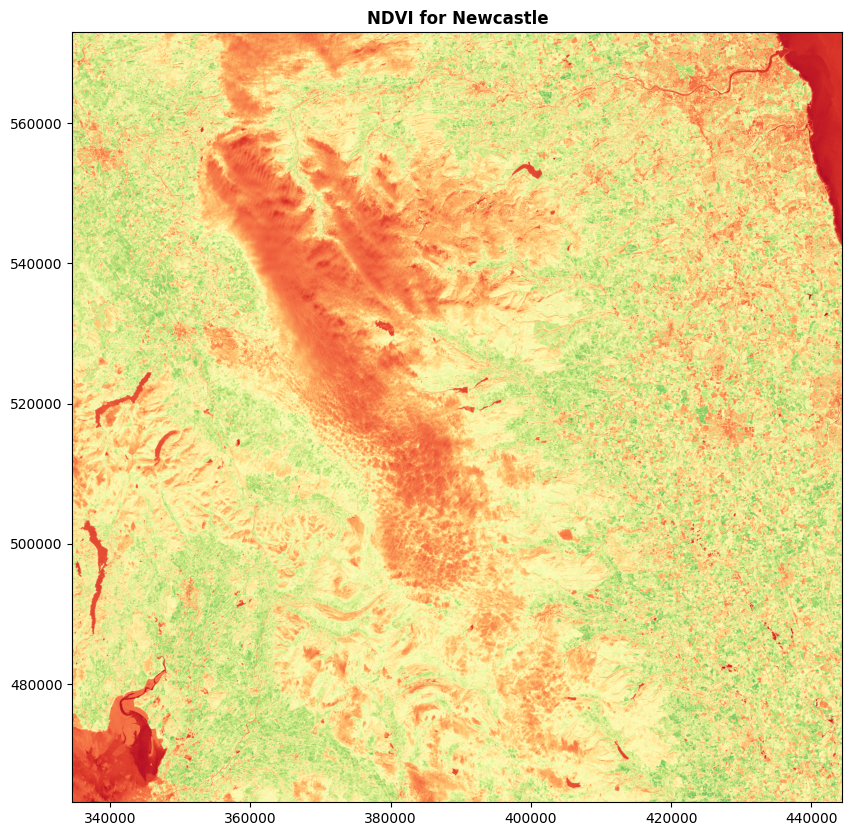

/tmp/ipython-input-1-3151057512.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(ndvi_plot.get_images()[0], label='NDVI Value')  # <- Fix here


<Figure size 640x480 with 0 Axes>

In [1]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
output_ndvi_path = "/content/drive/My Drive/ndvi_T30UWF_20250103T112451.tif"
plt.figure(figsize=(10, 10))
with rasterio.open(output_ndvi_path) as src:
    ndvi_plot = show(src, cmap='RdYlGn', vmin=-0.2, vmax=0.9, title="NDVI for Newcastle")
    plt.colorbar(ndvi_plot.get_images()[0], label='NDVI Value')
plt.show()





I reproject the image to EPSG:3857 because most web maps use this coordinate system. Converting the image lets us create map tiles that line up perfectly with these maps, so when you overlay the NDVI image, it fits in the right place on the map. This makes it easier to display and use the data in web apps

In [6]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

input_path = "/content/drive/My Drive/ndvi_T30UWF_20250103T112451.tif"
output_path = "/content/drive/My Drive/ndvi_epsg3857.tif"

dst_crs = "EPSG:3857"

with rasterio.open(input_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(output_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

print(f"Reprojected GeoTIFF saved at: {output_path}")


Reprojected GeoTIFF saved at: /content/drive/My Drive/ndvi_epsg3857.tif


In [7]:
pip install rio-cogeo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00


I create a Cloud Optimized GeoTIFF (COG) because it’s specially designed for fast and efficient access, especially when serving data over the web

In [10]:
!rio cogeo create "/content/drive/My Drive/ndvi_epsg3857.tif" "/content/drive/My Drive/ndvi_epsg3857_cog.tif" --overview-level 5 --resampling nearest


Reading input: /content/drive/My Drive/ndvi_epsg3857.tif
  [####################################]  100%          
Adding overviews...
Updating dataset tags...
Writing output to: /content/drive/My Drive/ndvi_epsg3857_cog.tif
